In [36]:
import pandas as pd
import numpy as np
import os
import json
from openai import OpenAI
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [ ]:
# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Obtener la clave de API de OpenAI desde las variables de entorno
api_key = os.getenv("OPENAI_API_KEY")

# Verificar que la clave de API se haya cargado correctamente
if api_key is None:
    raise ValueError("La clave de API de OpenAI no está definida en el archivo .env")

client = OpenAI(api_key=api_key)

In [29]:
# Cargar el archivo PDF utilizando PyPDFLoader

# Construir la ruta del archivo
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
file_path = os.path.join(parent_dir, 'data', 'llm_doc.pdf')

loader = PyPDFLoader(file_path)
documents = loader.load()

# Dividir el documento en fragmentos ('chunks')
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(documents)

# Crear el DataFrame del vector store
data = [{'Chunks': doc.page_content, 'Metadata': doc.metadata} for doc in doc_splits]
df_vector_store = pd.DataFrame(data)


In [32]:
# 3. Generación de embeddings y almacenamiento
def text_embedding(text):
    # Generar embeddings utilizando el modelo 'text-embedding-ada-002'
    embeddings = client.embeddings.create(model="text-embedding-ada-002",
                                          input=text,
                                          encoding_format="float")
    
    return embeddings.data[0].embedding


# Añadir una nueva columna 'Embedding' al DataFrame
df_vector_store["Embedding"] = df_vector_store["Chunks"].apply(lambda x: text_embedding([x]))
df_vector_store["Embedding"] = df_vector_store["Embedding"].apply(np.array)

# Guardar el DataFrame en un archivo pickle
df_vector_store.to_pickle('df_vector_store.pkl')

In [33]:
# Función para cargar las preguntas y respuestas desde el archivo .txt
def cargar_preguntas_respuestas_desde_txt(ruta_archivo):
    preguntas = []
    respuestas = []
    with open(ruta_archivo, 'r', encoding='utf-8') as f:
        contenido = f.read()
    bloques = contenido.strip().split('\n\n')
    for bloque in bloques:
        lineas = bloque.strip().split('\n')
        if len(lineas) >= 2:
            pregunta_line = lineas[0]
            respuesta_line = lineas[1]
            pregunta = pregunta_line.replace('Pregunta:', '').strip()
            respuesta = respuesta_line.replace('Respuesta:', '').strip()
            preguntas.append(pregunta)
            respuestas.append(respuesta)
    df = pd.DataFrame({'Pregunta': preguntas, 'Respuesta': respuestas})
    return df

In [41]:
# Ruta al archivo de texto con las preguntas y respuestas
questions_path = os.path.join(parent_dir, 'data', 'preguntas_respuestas.txt')
qa_df = cargar_preguntas_respuestas_desde_txt(questions_path)

In [43]:
# Funciones auxiliares
def get_context_for_question(question, vector_store, n_chunks=5):
    query_embedding = text_embedding(question)
    query_vector = np.array(query_embedding)
    
    def cosine_sim(row):
        return np.dot(row, query_vector) / (np.linalg.norm(row) * np.linalg.norm(query_vector))
    
    vector_store['Similarity'] = vector_store['Embedding'].apply(cosine_sim)
    top_chunks = vector_store.sort_values('Similarity', ascending=False).head(n_chunks)
    return list(top_chunks['Chunks'])

def construct_prompt(context_list):
    custom_prompt = f"""
Eres una Inteligencia Artificial avanzada que trabaja como asistente personal.
Utiliza los RESULTADOS DE BÚSQUEDA SEMÁNTICA para responder las preguntas del usuario.
Solo debes utilizar la información de la BÚSQUEDA SEMÁNTICA si es que hace sentido y tiene relación con la pregunta del usuario.
Si la respuesta no se encuentra dentro del contexto de la búsqueda semántica, no inventes una respuesta y responde amablemente que no tienes información para responder.

RESULTADOS DE BÚSQUEDA SEMÁNTICA:
{context_list}

Escribe una respuesta para el usuario.
"""
    return custom_prompt

def get_chatbot_response(question, prompt, temperature=0.0):
    response = client.chat.completions.create(
        model="gpt-4",
        temperature=temperature,
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": question}
        ]
    )
    return response.choices[0].message.content.strip()

def compute_similarity(answer1, answer2):
    vectorizer = TfidfVectorizer().fit_transform([answer1, answer2])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(vectors)
    return cosine_sim[0][1]

# Evaluación de las respuestas
accuracies = []
similarities = []

for index, row in qa_df.iterrows():
    question = row['Pregunta']
    proposed_answer = row['Respuesta']
    
    context_list = get_context_for_question(question, df_vector_store)
    prompt = construct_prompt(context_list)
    chatbot_answer = get_chatbot_response(question, prompt)
    
    similarity = compute_similarity(chatbot_answer, proposed_answer)
    similarities.append(similarity)
    
    # Umbral de similitud para considerar la respuesta correcta
    accuracies.append(similarity)
    
    print(f"Pregunta {index+1}: {question}")
    print(f"Respuesta Propuesta: {proposed_answer}")
    print(f"Respuesta del Chatbot: {chatbot_answer}")
    print(f"Similitud: {similarity:.2f}")
    print("-" * 50)

Pregunta 1: ¿Qué es un LLM?
Respuesta Propuesta: Un modelo de lenguaje entrenado con grandes volúmenes de texto para comprender y generar lenguaje.
Respuesta del Chatbot: Un LLM se refiere a un "Large Language Model" (Modelo de Lenguaje Grande, en español). Estos son modelos de inteligencia artificial que requieren recursos computacionales significativos para la recopilación de datos de texto. Los LLMs a menudo están compuestos de múltiples capas y componentes, como transformadores, redes neuronales recurrentes, mecanismos de atención y embeddings. Estos modelos se entrenan en grandes y diversos conjuntos de datos y se utilizan en diversas aplicaciones, como la traducción y la escritura creativa.
Similitud: 0.31
--------------------------------------------------
Pregunta 2: ¿Para qué se utilizan los LLM?
Respuesta Propuesta: Para tareas como generación de texto, traducción automática y comprensión del lenguaje.
Respuesta del Chatbot: Los Modelos de Lenguaje a Gran Escala (LLM, por sus 

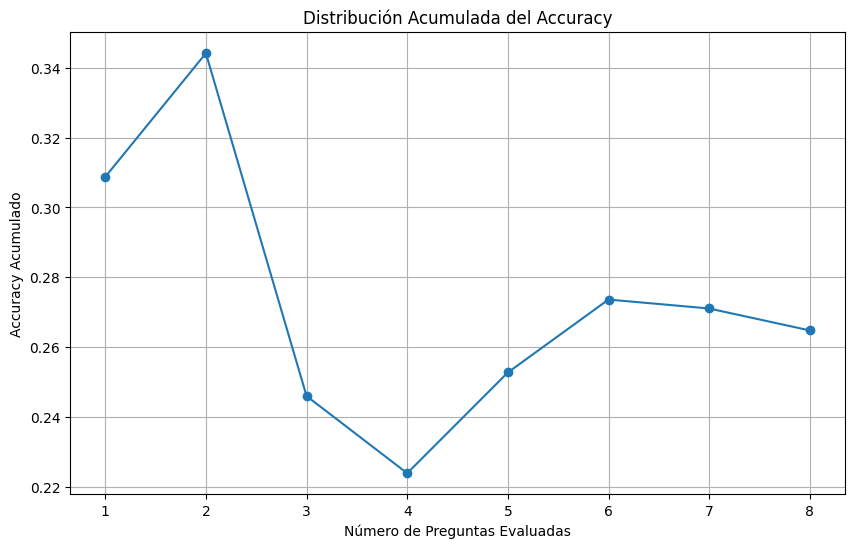

In [44]:
# Cálculo del accuracy acumulado
cumulative_accuracy = np.cumsum(accuracies) / np.arange(1, len(accuracies)+1)

# 6. Generación de la gráfica
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_accuracy)+1), cumulative_accuracy, marker='o')
plt.title('Distribución Acumulada del Accuracy')
plt.xlabel('Número de Preguntas Evaluadas')
plt.ylabel('Accuracy Acumulado')
plt.xticks(range(1, len(cumulative_accuracy)+1))
plt.grid(True)
plt.show()